# import stuff

In [1]:
import os
import numpy as np
import pandas as pd
import flopy 
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
import itertools as it


In [2]:
numcell = 5
nlay = 1
nrow = 1
ncol = numcell
top = 0
botm = -5

ib = np.ones((nrow,ncol))
#set first cell in first row to constant head
ib[(nrow-nrow),(ncol-ncol)] = -1
# set last cell in first row to contant head
ib[(nrow-1),(ncol-1)] = -1

#create array of starting heads (one indicates active I think)
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
#from ibound, only first and last cells have fixed head, assign these:
strt[:, :, 0] = 4.
strt[:, :, -1] = 0.

In [3]:
modelname = 'testETunconf'
m = flopy.modflow.Modflow(version = 'mf2005',exe_name = 'mf2005.exe',modelname = modelname)
Lx = 100
Ly = 100
nlay = 1
nrow = 1
ncol = numcell
nper = 1

delc = Ly/nrow
delr = Lx/ncol
laycbd = 0 
laytyp = 0 #zero for confined or convertible (will act like confined when fully saturated)
botm = -5
top = 0 #for confined, top equals lowest top from unconfined case at H1, for unconfined, top = 100
nstp = 1
tsmult = 1
steady = True

dis = flopy.modflow.ModflowDis(m,nlay=nlay,nrow=nrow,ncol=ncol,nper=nper,delr=delr,delc=delc,laycbd=laycbd,top=top
,botm=botm,nstp=nstp,tsmult=tsmult,steady=steady)
flow = []
heads = []



bas = flopy.modflow.ModflowBas(m,ibound = ib,strt = strt)
lpf = flopy.modflow.ModflowLpf(m,laytyp=1,ipakcb=50)

In [4]:
def modelrun_fixed(name):
    k=0
    j=0
    spd = {0:[[0,0,0,j],[0,0,1,k]]}
    wel = flopy.modflow.ModflowWel(m,ipakcb = 50,stress_period_data=spd)
    gmg = flopy.modflow.ModflowGmg(m)
    oc = flopy.modflow.ModflowOc(m)
    oc.stress_period_data[0,0] = ['save head', 'save budget', 'print head', 'print budget']
    print(top)
    print(j)

    m.write_input()
    m.run_model()


    hds = bf.HeadFile(modelname+'.hds') #read binary head file output from modflow
    times = hds.get_times() #not sure
    head = hds.get_data(totim=times[-1]) #assign result of reading binary file to variable 'head'
    heads.append(head)
    levels = np.linspace(0, 10, 11) #not sure
    cbb = bf.CellBudgetFile(modelname+'.cbc') #this is how you read the budget file, which is binary
    kstpkper_list = cbb.get_kstpkper() #variable that contains the results....maybe?
    frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0] #write to text for each result
    flow.append(frf)
    print(laytyp)
        
    return flow, heads;

In [5]:
def modelrun_et(name):
    j = 0
    k = -2.5
    spd = {0:[[0,0,0,k],[0,0,1,k],[0,0,2,k],[0,0,3,k],[0,0,4,k]]}
    wel = flopy.modflow.ModflowWel(m,ipakcb = 50,stress_period_data=spd)
    #evt = flopy.modflow.ModflowEvt(m, nevtop=3, evtr=.001)
    gmg = flopy.modflow.ModflowGmg(m)
    oc = flopy.modflow.ModflowOc(m)
    oc.stress_period_data[0,0] = ['save head', 'save budget', 'print head', 'print budget']
    print(top)
    print(j)

    m.write_input()
    m.run_model()


    hds = bf.HeadFile(modelname+'.hds') #read binary head file output from modflow
    times = hds.get_times() #not sure
    head = hds.get_data(totim=times[-1]) #assign result of reading binary file to variable 'head'
    heads.append(head)
    levels = np.linspace(0, 10, 11) #not sure
    cbb = bf.CellBudgetFile(modelname+'.cbc') #this is how you read the budget file, which is binary
    kstpkper_list = cbb.get_kstpkper() #variable that contains the results....maybe?
    frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0] #write to text for each result
    flow.append(frf)
    print(laytyp)
    #mf_list = MfListBudget(modelname+".list")
    #budget = mf_list.get_budget(names = None)
    
#     evt = flopy.modflow.mfevt.ModflowEvt(mf, surf=ztop, evtr=ET, exdp=extinction_depth, ipakcb=53)                       # EVT (Evapotranspiration)

    return flow, heads;

In [6]:
noETconf = modelrun_fixed(modelname)

C:\Users\Libby\Anaconda3\envs\flopy\lib\site-packages\flopy\modflow\mfdis.py:164: UserWarning: ModflowDis.sr is deprecated. use Modflow.sr
  warnings.warn("ModflowDis.sr is deprecated. use Modflow.sr")


0
0
FloPy is using the following executable to run the model: C:\GWV6\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: testETunconf.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/06/09 15:41:13

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/06/09 15:41:13
 Elapsed run time:  0.009 Seconds

  Normal termination of simulation
0


C:\Users\Libby\Anaconda3\envs\flopy\lib\site-packages\flopy\utils\binaryfile.py:811: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  self.file.seek(ipos, 0)


In [7]:
flow

[array([[[ 25.,  25.,  25.,  25.,   0.]]], dtype=float32)]

In [8]:
noETc = []
for i in range(ncol):
    new = heads[0][0][0][i]
    noETc.append(new)
    
noETcQ = []
for i in range(ncol):
    new = flow[0][0][0][i]
    noETcQ.append(new)

noETc = np.asarray(noETc)
noETcQ = np.asarray(noETcQ)

In [9]:
noETcQ

array([ 25.,  25.,  25.,  25.,   0.], dtype=float32)

In [10]:
heads = []
flow = []

In [11]:
ETconf = modelrun_et(modelname)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfwel.ModflowWel'> <class 'flopy.modflow.mfwel.ModflowWel'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfgmg.ModflowGmg'> <class 'flopy.modflow.mfgmg.ModflowGmg'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfoc.ModflowOc'> <class 'flopy.modflow.mfoc.ModflowOc'>
replacing existing Package...
0
0
FloPy is using the following executable to run the model: C:\GWV6\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: testETunconf.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/06/09 15:41:14

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/06/

C:\Users\Libby\Anaconda3\envs\flopy\lib\site-packages\flopy\modflow\mfdis.py:164: UserWarning: ModflowDis.sr is deprecated. use Modflow.sr
  warnings.warn("ModflowDis.sr is deprecated. use Modflow.sr")
C:\Users\Libby\Anaconda3\envs\flopy\lib\site-packages\flopy\utils\binaryfile.py:811: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  self.file.seek(ipos, 0)


In [12]:
ETc = []
for i in range(ncol):
    new = heads[0][0][0][i]
    ETc.append(new)

ETcQ = []
for i in range(ncol):
    new = flow[0][0][0][i]
    ETcQ.append(new)
    
ETc = np.asarray(ETc)
ETcQ = np.asarray(ETcQ)

In [13]:
heads = []
flow = []

In [14]:
noETc

array([ 4.,  3.,  2.,  1.,  0.], dtype=float32)

In [15]:
ETcQ

array([ 28.75      ,  26.24999809,  23.75      ,  21.25      ,   0.        ], dtype=float32)

# Reset and rerun for "unconfined" case

In [16]:
numcell = 5
nlay = 1
nrow = 1
ncol = numcell
top = 0
botm = -5

ib = np.ones((nrow,ncol))
#set first cell in first row to constant head
ib[(nrow-nrow),(ncol-ncol)] = -1
# set last cell in first row to contant head
ib[(nrow-1),(ncol-1)] = -1

#create array of starting heads (one indicates active I think)
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
#from ibound, only first and last cells have fixed head, assign these:
strt[:, :, 0] = 0.1
strt[:, :, -1] = -4.1

In [17]:
modelname = 'testETunconf'
m = flopy.modflow.Modflow(version = 'mf2005',exe_name = 'mf2005.exe',modelname = modelname)
Lx = 100
Ly = 100
nlay = 1
nrow = 1
ncol = numcell
nper = 1

delc = Ly/nrow
delr = Lx/ncol
laycbd = 0 
laytyp = 0 #zero for confined or convertible (will act like confined when fully saturated)
botm = -5
top = 0 #for confined, top equals lowest top from unconfined case at H1, for unconfined, top = 100
nstp = 1
tsmult = 1
steady = True

dis = flopy.modflow.ModflowDis(m,nlay=nlay,nrow=nrow,ncol=ncol,nper=nper,delr=delr,delc=delc,laycbd=laycbd,top=top
,botm=botm,nstp=nstp,tsmult=tsmult,steady=steady)
flow = []
heads = []



bas = flopy.modflow.ModflowBas(m,ibound = ib,strt = strt)
lpf = flopy.modflow.ModflowLpf(m,laytyp=1,ipakcb=50)

In [18]:
noETu = modelrun_fixed(modelname)

0
0
FloPy is using the following executable to run the model: C:\GWV6\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: testETunconf.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/06/09 15:41:15

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/06/09 15:41:15
 Elapsed run time:  0.000 Seconds

  Normal termination of simulation
0


C:\Users\Libby\Anaconda3\envs\flopy\lib\site-packages\flopy\modflow\mfdis.py:164: UserWarning: ModflowDis.sr is deprecated. use Modflow.sr
  warnings.warn("ModflowDis.sr is deprecated. use Modflow.sr")
C:\Users\Libby\Anaconda3\envs\flopy\lib\site-packages\flopy\utils\binaryfile.py:811: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  self.file.seek(ipos, 0)


In [19]:
heads

[array([[[ 0.1       , -0.49986044, -1.18830526, -2.04121685, -4.0999999 ]]], dtype=float32)]

In [20]:
noETu = []
for i in range(ncol):
    new1 = heads[0][0][0][i]
    noETu.append(new1)
    
noETuQ = []
for i in range(ncol):
    new2 = flow[0][0][0][i]
    noETuQ.append(new2)
    
noETu = np.asarray(noETu)
noETuQ = np.asarray(noETuQ)

In [21]:
noETu

array([ 0.1       , -0.49986044, -1.18830526, -2.04121685, -4.0999999 ], dtype=float32)

In [22]:
heads = []
flow = []

In [23]:
noETu

array([ 0.1       , -0.49986044, -1.18830526, -2.04121685, -4.0999999 ], dtype=float32)

In [24]:
ETu = modelrun_et(modelname)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfwel.ModflowWel'> <class 'flopy.modflow.mfwel.ModflowWel'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfgmg.ModflowGmg'> <class 'flopy.modflow.mfgmg.ModflowGmg'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfoc.ModflowOc'> <class 'flopy.modflow.mfoc.ModflowOc'>
replacing existing Package...
0
0
FloPy is using the following executable to run the model: C:\GWV6\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: testETunconf.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/06/09 15:41:16

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/06/

C:\Users\Libby\Anaconda3\envs\flopy\lib\site-packages\flopy\modflow\mfdis.py:164: UserWarning: ModflowDis.sr is deprecated. use Modflow.sr
  warnings.warn("ModflowDis.sr is deprecated. use Modflow.sr")
C:\Users\Libby\Anaconda3\envs\flopy\lib\site-packages\flopy\utils\binaryfile.py:811: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  self.file.seek(ipos, 0)


In [25]:
ETu = []
for i in range(ncol):
    new1 = heads[0][0][0][i]
    ETu.append(new1)
    
ETuQ = []
for i in range(ncol):
    new2 = flow[0][0][0][i]
    ETuQ.append(new2)
    
ETu = np.asarray(ETu)
ETuQ = np.asarray(ETuQ)

df1 = pd.DataFrame(noETc,ETc,noETu,ETu)
df1.to_csv("hds.csv")

In [26]:
ETu

array([ 0.1       , -0.69941223, -1.53188324, -2.44918919, -4.0999999 ], dtype=float32)

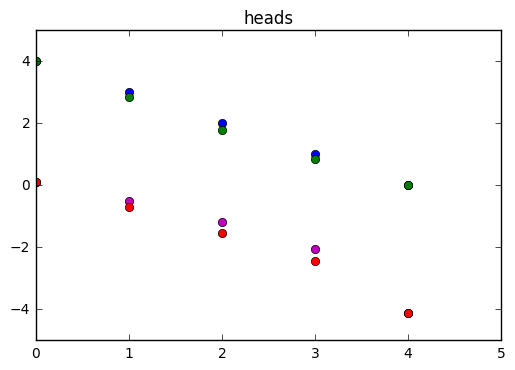

In [27]:

plt.plot(noETu,'mo')
plt.plot(ETu,'ro')
plt.plot(noETc,'bo')
plt.plot(ETc,'go')
plt.title('heads')

axes = plt.gca()
axes.set_xlim([0,5])
axes.set_ylim([-5,5])
plt.show()

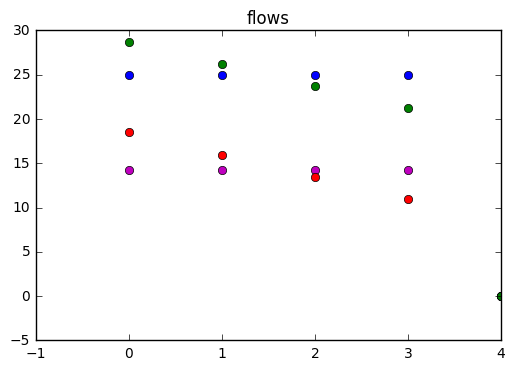

In [28]:
plt.plot(noETuQ,'mo')
plt.plot(ETuQ,'ro')
plt.plot(noETcQ,'bo')
plt.plot(ETcQ,'go')
plt.title('flows')

axes = plt.gca()
axes.set_xlim([-1,4])
axes.set_ylim([-5,30])
plt.show()

# it's time.

In [29]:
noETuGradH = []
ETuGradH = []
noETcGradH = []
ETcGradH = []

for i in range(ncol-1):
    dH1 = noETu[i+1] - noETu[i]
    dH2 = ETu[i+1] - ETu[i]
    dH3 = noETc[i+1] - noETc[i]
    dH4 = ETc[i+1] - ETc[i]
    noETuGradH.append(dH1)
    ETuGradH.append(dH2)
    noETcGradH.append(dH3)
    ETcGradH.append(dH4)
    

In [30]:
noETuR = []
ETuR = []
noETcR = []
ETcR = []

for i in range(ncol-1):
    R1 = noETuGradH[i]/noETuQ[i]
    R2 = ETuGradH[i]/ETuQ[i]
    R3 = noETcGradH[i]/noETcQ[i]
    R4 = ETcGradH[i]/ETcQ[i]
    noETuR.append(R1)
    ETuR.append(R2)
    noETcR.append(R3)
    ETcR.append(R4)

# gradient and R...now what is base and pert?
1. one base is confined conditions, the other is no ET
2. need to calculate three delR/delV's
    a. confined, no ET = base, unconfined, no ET is pert
    b. confined, no ET = base, confined, ET is pert
    c. unconfined, no ET = base, unconfined, ET is pert
    d. Confined, no ET = base, unconfined, with ET is pert
3. compare phi values from all cases.

In [31]:
phiA = []
phiB = []
phiC = []
phiD = []

for i in range(ncol-1):
    phi1 = (noETuR[i] - noETcR[i])/(noETuGradH[i] - noETcGradH[i])
    phi2 = (ETcR[i] - noETcR[i])/(ETcGradH[i] - noETcGradH[i])
    phi3 = (ETuR[i] - noETuR[i])/(ETuGradH[i] - noETuGradH[i])
    phi4 = (ETuR[i] - noETcR[i])/(ETuGradH[i] - noETcGradH[i])
    phiA.append(phi1)
    phiB.append(phi2)
    phiC.append(phi3)
    phiD.append(phi4)

In [32]:
ETuGradH

[-0.79941225, -0.83247101, -0.91730595, -1.6508107]

In [33]:
noETcGradH

[-1.0, -1.0, -1.0, -1.0]

In [34]:
phiA

[-0.0055519305, -0.027143233, -0.13619503, 0.099084236]

In [35]:
phiB

[2.4835252e-08, 7.4505877e-08, 7.4505699e-08, -2.4835273e-08]

In [36]:
phiC

[0.0051670638, 0.025204796, 0.12430625, -0.01324993]

In [37]:
phiD

[-0.016215567, -0.072147302, -0.33904895, 0.16950291]

# does it make sense? 
1. phiA is negative because unconfining the system represents a negative feedback (more flow through unconfined translates to less of a change in the head gradient than for unconfined)
2. phiB is positive because including ET increases the amount of flow through the system, 
3. phiC positive for the same reason
4. phiD is negative, and it is more negative than phiA. There is greater change in the unconfined system with ET

In [38]:
#create array of starting heads (one indicates active I think)
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
#from ibound, only first and last cells have fixed head, assign these:
strt[:, :, 0] = 4.1
strt[:, :, -1] = 0.

In [39]:
modelname = 'testETunconf'
m = flopy.modflow.Modflow(version = 'mf2005',exe_name = 'mf2005.exe',modelname = modelname)
Lx = 100
Ly = 100
nlay = 1
nrow = 1
ncol = numcell
nper = 1

delc = Ly/nrow
delr = Lx/ncol
laycbd = 0 
laytyp = 0 #zero for confined or convertible (will act like confined when fully saturated)
botm = -5
top = 0 #for confined, top equals lowest top from unconfined case at H1, for unconfined, top = 100
nstp = 1
tsmult = 1
steady = True

dis = flopy.modflow.ModflowDis(m,nlay=nlay,nrow=nrow,ncol=ncol,nper=nper,delr=delr,delc=delc,laycbd=laycbd,top=top
,botm=botm,nstp=nstp,tsmult=tsmult,steady=steady)
flow = []
heads = []



bas = flopy.modflow.ModflowBas(m,ibound = ib,strt = strt)
lpf = flopy.modflow.ModflowLpf(m,laytyp=1,ipakcb=50)

In [40]:
noETcPert = modelrun_fixed(modelname)

0
0
FloPy is using the following executable to run the model: C:\GWV6\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: testETunconf.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/06/09 15:41:18

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/06/09 15:41:18
 Elapsed run time:  0.000 Seconds

  Normal termination of simulation
0


C:\Users\Libby\Anaconda3\envs\flopy\lib\site-packages\flopy\modflow\mfdis.py:164: UserWarning: ModflowDis.sr is deprecated. use Modflow.sr
  warnings.warn("ModflowDis.sr is deprecated. use Modflow.sr")
C:\Users\Libby\Anaconda3\envs\flopy\lib\site-packages\flopy\utils\binaryfile.py:811: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  self.file.seek(ipos, 0)


In [41]:
noETcP = []
for i in range(ncol):
    new = heads[0][0][0][i]
    noETcP.append(new)
    
noETcQP = []
for i in range(ncol):
    new = flow[0][0][0][i]
    noETcQP.append(new)

noETcP = np.asarray(noETcP)
noETcQP = np.asarray(noETcQP)

In [42]:
heads = []
flow = []

In [43]:
ETcPert = modelrun_et(modelname)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfwel.ModflowWel'> <class 'flopy.modflow.mfwel.ModflowWel'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfgmg.ModflowGmg'> <class 'flopy.modflow.mfgmg.ModflowGmg'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfoc.ModflowOc'> <class 'flopy.modflow.mfoc.ModflowOc'>
replacing existing Package...
0
0
FloPy is using the following executable to run the model: C:\GWV6\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: testETunconf.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/06/09 15:41:19

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/06/

C:\Users\Libby\Anaconda3\envs\flopy\lib\site-packages\flopy\modflow\mfdis.py:164: UserWarning: ModflowDis.sr is deprecated. use Modflow.sr
  warnings.warn("ModflowDis.sr is deprecated. use Modflow.sr")
C:\Users\Libby\Anaconda3\envs\flopy\lib\site-packages\flopy\utils\binaryfile.py:811: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  self.file.seek(ipos, 0)


In [44]:
ETcP = []
for i in range(ncol):
    new = heads[0][0][0][i]
    ETcP.append(new)
    
ETcQP = []
for i in range(ncol):
    new = flow[0][0][0][i]
    ETcQP.append(new)

ETcP = np.asarray(noETcP)
ETcQP = np.asarray(noETcQP)

In [45]:
numcell = 5
nlay = 1
nrow = 1
ncol = numcell
top = 0
botm = -5

ib = np.ones((nrow,ncol))
#set first cell in first row to constant head
ib[(nrow-nrow),(ncol-ncol)] = -1
# set last cell in first row to contant head
ib[(nrow-1),(ncol-1)] = -1

#create array of starting heads (one indicates active I think)
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
#from ibound, only first and last cells have fixed head, assign these:
strt[:, :, 0] = 0.
strt[:, :, -1] = -4.1

In [46]:
modelname = 'testETunconf'
m = flopy.modflow.Modflow(version = 'mf2005',exe_name = 'mf2005.exe',modelname = modelname)
Lx = 100
Ly = 100
nlay = 1
nrow = 1
ncol = numcell
nper = 1

delc = Ly/nrow
delr = Lx/ncol
laycbd = 0 
laytyp = 0 #zero for confined or convertible (will act like confined when fully saturated)
botm = -5
top = 0 #for confined, top equals lowest top from unconfined case at H1, for unconfined, top = 100
nstp = 1
tsmult = 1
steady = True

dis = flopy.modflow.ModflowDis(m,nlay=nlay,nrow=nrow,ncol=ncol,nper=nper,delr=delr,delc=delc,laycbd=laycbd,top=top
,botm=botm,nstp=nstp,tsmult=tsmult,steady=steady)
flow = []
heads = []



bas = flopy.modflow.ModflowBas(m,ibound = ib,strt = strt)
lpf = flopy.modflow.ModflowLpf(m,laytyp=1,ipakcb=50)

In [47]:
noETuPert = modelrun_fixed(modelname)

0
0
FloPy is using the following executable to run the model: C:\GWV6\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: testETunconf.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/06/09 15:41:19

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/06/09 15:41:19
 Elapsed run time:  0.000 Seconds

  Normal termination of simulation
0


C:\Users\Libby\Anaconda3\envs\flopy\lib\site-packages\flopy\modflow\mfdis.py:164: UserWarning: ModflowDis.sr is deprecated. use Modflow.sr
  warnings.warn("ModflowDis.sr is deprecated. use Modflow.sr")
C:\Users\Libby\Anaconda3\envs\flopy\lib\site-packages\flopy\utils\binaryfile.py:811: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  self.file.seek(ipos, 0)


In [48]:
noETuP = []
for i in range(ncol):
    new = heads[0][0][0][i]
    noETuP.append(new)
    
noETuQP = []
for i in range(ncol):
    new = flow[0][0][0][i]
    noETuQP.append(new)

noETuP = np.asarray(noETuP)
noETuQP = np.asarray(noETuQP)

In [49]:
heads = []
flow = []

In [50]:
ETuPert = modelrun_et(modelname)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfwel.ModflowWel'> <class 'flopy.modflow.mfwel.ModflowWel'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfgmg.ModflowGmg'> <class 'flopy.modflow.mfgmg.ModflowGmg'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfoc.ModflowOc'> <class 'flopy.modflow.mfoc.ModflowOc'>
replacing existing Package...
0
0
FloPy is using the following executable to run the model: C:\GWV6\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: testETunconf.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/06/09 15:41:19

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/06/

C:\Users\Libby\Anaconda3\envs\flopy\lib\site-packages\flopy\modflow\mfdis.py:164: UserWarning: ModflowDis.sr is deprecated. use Modflow.sr
  warnings.warn("ModflowDis.sr is deprecated. use Modflow.sr")
C:\Users\Libby\Anaconda3\envs\flopy\lib\site-packages\flopy\utils\binaryfile.py:811: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  self.file.seek(ipos, 0)


In [51]:
ETuP = []
for i in range(ncol):
    new = heads[0][0][0][i]
    ETuP.append(new)
    
ETuQP = []
for i in range(ncol):
    new = flow[0][0][0][i]
    ETuQP.append(new)

ETuP = np.asarray(ETuP)
ETuQP = np.asarray(ETuQP)

In [52]:
noETuGradHP = []
ETuGradHP = []
noETcGradHP = []
ETcGradHP = []

for i in range(ncol-1):
    dH1 = noETuP[i+1] - noETuP[i]
    dH2 = ETuP[i+1] - ETuP[i]
    dH3 = noETcP[i+1] - noETcP[i]
    dH4 = ETcP[i+1] - ETcP[i]
    noETuGradHP.append(dH1)
    ETuGradHP.append(dH2)
    noETcGradHP.append(dH3)
    ETcGradHP.append(dH4)

In [53]:
noETuRP = []
ETuRP = []
noETcRP = []
ETcRP = []

for i in range(ncol-1):
    R1 = noETuGradHP[i]/noETuQP[i]
    R2 = ETuGradHP[i]/ETuQP[i]
    R3 = noETcGradHP[i]/noETcQP[i]
    R4 = ETcGradHP[i]/ETcQP[i]
    noETuRP.append(R1)
    ETuRP.append(R2)
    noETcRP.append(R3)
    ETcRP.append(R4)

In [65]:
phinoETu = []
phiETc = []
phiETu = []
phinoETc = []

for i in range(ncol-1):
    phi1 = (noETuRP[i] - noETuR[i])/(noETuGradHP[i] - noETuGradH[i])
    phi2 = (ETcRP[i] - ETcR[i])/(ETcGradHP[i] - ETcGradH[i])
    phi3 = (ETuRP[i] - ETuR[i])/(ETuGradHP[i] - ETuGradH[i])
    phi4 = (noETcRP[i] - noETcR[i])/(noETcGradHP[i] - noETcGradH[i])
    phinoETu.append(phi1)
    phiETc.append(phi2)
    phiETu.append(phi3)
    phinoETc.append(phi4)

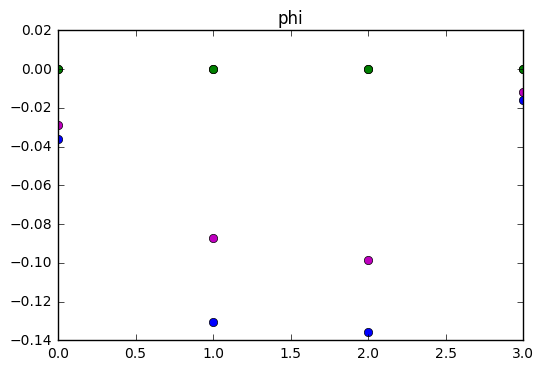

C:\Users\Libby\Anaconda3\envs\flopy\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [66]:
plt.plot(phinoETu,'mo')
plt.plot(phiETc,'ro')
plt.plot(phiETu,'bo')
plt.plot(phinoETc,'go')
plt.title('phi')

axes = plt.gca()
# axes.set_xlim([-1,4])
# axes.set_ylim([-5,30])
plt.show()
plt.legend()

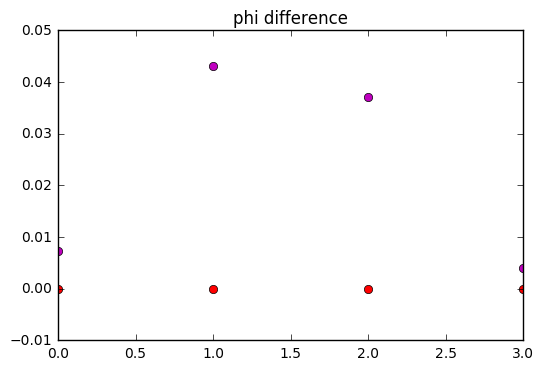

In [67]:
tempAA=np.asarray(phinoETu)
tempBB=np.asarray(phiETc)
tempCC=np.asarray(phiETu)
tempDD=np.asarray(phinoETc)
plt.plot(tempAA-tempCC,'mo')
plt.plot(tempBB-tempDD,'ro')
plt.title('phi difference')


axes = plt.gca()
# axes.set_xlim([-1,4])
# axes.set_ylim([-5,30])
plt.show()
plt.savefig('phidiff.pdf')